In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import constants as c
from collections import Counter
import pandas as pd
from datetime import datetime
from paddleocr import PaddleOCR
import imutils
from scipy import stats
import statistics as stat

In [ ]:
ocr = PaddleOCR(lang='en',  use_angle_cls=True)

In [31]:
def get_sign(posicao, image):
    #posicao: vetor de ints, posicao no formato [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    #imagem: imagem colorida (antes de passar pela função prepare_image)
    #return: int 
    
    cropped_image = image[int(posicao[0][1]):int(posicao[2][1]), int(posicao[0][0]):int(posicao[1][0])]
    #plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    #plt.show()
    branco = []
    preto = []
    for col in cropped_image:
        for linha in col:
            if np.all(linha>200):
                branco.append((col,linha))
            if np.all(linha<55):
                preto.append((col,linha))

    sign = 1
    if len(branco)<len(preto):
        sign = -1
    
    return sign

def drop_outliers(angles):
  if angles:
      z = np.abs(stats.zscore(angles))
      #print(z)
      if np.all(np.isnan(z)):
          return angles
      new_angles = []
      for i in range(len(angles)):
          if z[i]<1.3 and z[i]> 0.3:
              new_angles.append(angles[i])
      return new_angles

def final_angle(angles):
  if angles:
    m = round(np.mean(angles),0)
    mode = round(stat.mode((angles)),0)
    if abs(m - mode)> 5:
      return None
    return m
  return None

def get_escala(dist_escala, vet_dist):
    est_escala = []
    for i in range(len(vet_dist)-1):
        for j in range(i, len(vet_dist)-1):
            if vet_dist[j]!=vet_dist[j+1]:
                dif = abs(vet_dist[j]-vet_dist[j+1])
                div = round(dif/dist_escala,0)
                if div:
                    e = dif / div
                    est_escala.append(round(e,1))
    real_escala = c.F5_dist_pitch_escala
    if len(est_escala):
        real_escala = round(np.mean(est_escala),0)
    return real_escala


def get_vet_dist_angle(img, center, ref_angles):
    vet_dist = []
    number_ref_angles = []
    for linha in ref_angles:
        try:
            angle = int(linha[1][0])
        except:
            angle = None
        pos1 = linha[0][0][1]
        pos2 = linha[0][3][1]
        sign = get_sign(linha[0], img)
        if angle and not angle%c.F5_pitch_escala:
            angle = sign*angle
            dist = round(center[0]/2-(pos1+pos2)/2,0)
            vet_dist.append(dist)
            number_ref_angles.append(angle)
            
    return vet_dist, number_ref_angles

def get_state(roll_angle, ref_angles, inv):
    ref_sign = np.sign(roll_angle)
    states = []
    for i in range(len(ref_angles)-1):
        if ref_angles[i+1] < ref_angles[i]:
            if roll_angle >= 0:
                if not inv:
                    states.append(c.NORMAL_POS)
                else:
                    state = c.DORSO_OUT
                    states.append(c.DORSO_OUT)

            else:
                if not inv:
                    states.append(c.NORMAL_NEG)
                else:
                    states.append(c.DORSO_IN)
                    
        elif ref_angles[i+1] > ref_angles[i]:
            if roll_angle >= 0:
                if not inv:
                    states.append(c.DORSO_OUT)
                else:
                    states.append(c.NORMAL_POS)
            else:
                if not inv:
                    states.append(c.DORSO_IN)
                else:
                    states.append(c.NORMAL_NEG)
    state = None
    if len(states)>0:
        state = stat.mode(states)
    return state, ref_sign


def change_state(change, roll_angle, current_state):
    next_state = current_state
    if change:
        if current_state == c.NORMAL_POS:
            if abs(roll_angle) > 45:
                next_state = c.DORSO_IN
            elif abs(roll_angle):
                next_state = c.NORMAL_NEG

        elif current_state == c.NORMAL_NEG:
            if abs(roll_angle) > 45:
                next_state = c.DORSO_OUT
            else:
                next_state = c.NORMAL_POS

        elif current_state == c.DORSO_OUT:
            if abs(roll_angle) > 45:
                next_state = c.NORMAL_NEG
            elif abs(roll_angle):
                next_state = c.DORSO_IN

        elif current_state == c.DORSO_IN:
            if abs(roll_angle) > 45:
                next_state = c.NORMAL_POS
            else:
                next_state = c.DORSO_OUT
    
    return next_state

In [120]:
df  = pd.DataFrame()
df1  = pd.DataFrame()
roll_angles_df = pd.read_csv('csv/F5/roll_angle_1017_1055.csv')
directory = '../frames/F5_1_rotated/'
pitch = []
estados = []
ref_sign = None
state = None
change = False
frame_conf = -1
inv = False
ini = 0
fim = 7470


for i in range(ini, fim):
    
    path = directory +  str(i) + '.png' 
    image = cv2.imread(path)
    roll_angle = roll_angles_df["roll_angle"][i]

    if not np.isnan(roll_angle):
        current_sign = np.sign(roll_angle)
        if current_sign == 0:
            current_sign = 1
        image = imutils.rotate_bound(image, roll_angle)
        ref_angles = ocr.ocr(image, cls=True)
        center = image.shape

        if ref_sign and current_sign and ref_sign != current_sign:
            change = True
        else:
            change = False
        
        vet_dist, angles = get_vet_dist_angle( image, center, ref_angles)
        
        if state == None:
            state, ref_sign = get_state(roll_angle, angles,inv)
            frame_conf = i
            if state == None:
                inv = True
                image = imutils.rotate_bound(image, 180)
                ref_angles = ocr.ocr(image, cls=True)
                center = image.shape

                vet_dist, angles = get_vet_dist_angle( image, center, ref_angles)
                
                state, ref_sign = get_state(roll_angle, angles,inv)
                frame_conf = i
            if ref_sign == 0:
                ref_sign = 1
        else:
            if change:
                state = change_state(change, roll_angle, state)
        estados.append(state)
        if state:
            real_escala = get_escala(c.F5_dist_pitch_escala, vet_dist)
            
            pitch_angles = []
            angle_estimado = None
            for j in range(len(angles)):
                
                if state == c.NORMAL_POS or state == c.NORMAL_NEG:
                    if not inv:
                        angle_estimado = angles[j] - vet_dist[j]*c.F5_pitch_escala/real_escala
                    else: 
                        angle_estimado = angles[j] + vet_dist[j]*c.F5_pitch_escala/real_escala
                else:
                    if not inv:
                        angle_estimado = angles[j] + vet_dist[j]*c.F5_pitch_escala/real_escala
                    else: 
                        angle_estimado = angles[j] - vet_dist[j]*c.F5_pitch_escala/real_escala
                
                angle_estimado = round(angle_estimado,0)
                pitch_angles.append(angle_estimado)
            

            pitch_angles = drop_outliers(pitch_angles)
            pitch_angle = final_angle(pitch_angles)

            pitch.append(pitch_angle)

        else:
            pitch.append(None)
            estados.append(None)

        ref_sign = current_sign
        inv = False
    
    else:
        pitch.append(None)
        estados.append(None)
    print(i)

df["pitch_angle"] = pitch
df1["estado"] = estados

path = 'csv/F5/pitch_angle_' + datetime.today().strftime('%m%d_%H%M') + '.csv'
df.to_csv(path, index= False)

path2 = 'csv/F5/estados_' + datetime.today().strftime('%m%d_%H%M') + '.csv'
df1.to_csv(path2, index= False)

[2022/10/17 20:13:59] ppocr DEBUG: dt_boxes num : 5, elapse : 0.05123639106750488
[2022/10/17 20:13:59] ppocr DEBUG: cls num  : 5, elapse : 0.1134188175201416
[2022/10/17 20:13:59] ppocr DEBUG: rec_res num  : 5, elapse : 0.6443250179290771
0
[2022/10/17 20:14:00] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04986929893493652
[2022/10/17 20:14:00] ppocr DEBUG: cls num  : 5, elapse : 0.07280492782592773
[2022/10/17 20:14:00] ppocr DEBUG: rec_res num  : 5, elapse : 0.6480474472045898
1
[2022/10/17 20:14:00] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04492020606994629
[2022/10/17 20:14:00] ppocr DEBUG: cls num  : 5, elapse : 0.07134413719177246
[2022/10/17 20:14:01] ppocr DEBUG: rec_res num  : 5, elapse : 0.6393301486968994
2
[2022/10/17 20:14:01] ppocr DEBUG: dt_boxes num : 5, elapse : 0.04165983200073242
[2022/10/17 20:14:01] ppocr DEBUG: cls num  : 5, elapse : 0.07978558540344238
[2022/10/17 20:14:02] ppocr DEBUG: rec_res num  : 5, elapse : 0.648125171661377
3
[2022/10/17 20:14:02] ppocr DE

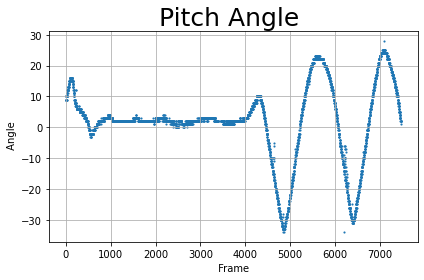

In [143]:
df1 = pd.read_csv('csv/F5/pitch_angle_1017_2312.csv')
df = df1.copy()
for column in df:
  inst = str(column)
  
  fig, ax = plt.subplots()

  x = df.index.tolist()
  y = df[column].values.tolist()
  ax.scatter(x,y, marker=".", s =5)
  plt.grid ()
  plt.title("Pitch Angle ",fontsize=25)
  plt.xlabel ( ' Frame ')
  plt.ylabel ( ' Angle')
  plt.tight_layout ()
  
  
  plt.show()

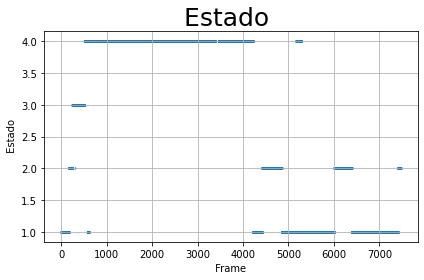

In [144]:
df1 = pd.read_csv('csv/F5/estados_1017_2312.csv')
df = df1.copy()
for column in df:
  inst = str(column)
  
  fig, ax = plt.subplots()

  x = df.index.tolist()
  y = df[column].values.tolist()
  ax.scatter(x,y, marker=".", s =5)
  plt.grid ()
  plt.title("Estado ",fontsize=25)
  plt.xlabel ( ' Frame ')
  plt.ylabel ( ' Estado')
  plt.tight_layout ()
  
  
  plt.show()

In [123]:
df1 = pd.read_csv('csv/F5/estados_1017_2312.csv')
states = np.array(df1["estado"].tolist())
x_idx = [[],[],[],[],[]]
state = states[0]
aux =False
try:
    state = int(states[0])
    x_idx[state].append(0)
except:
    state = None
for i in range(1,len(states)):
    try:
        current_state = int(states[i])
    except:
        current_state = None
    if state and current_state and state!=current_state:
        x_idx[state].append(i)
        x_idx[current_state].append(i)
    if current_state:
        state = current_state

x_idx[state].append(len(states))


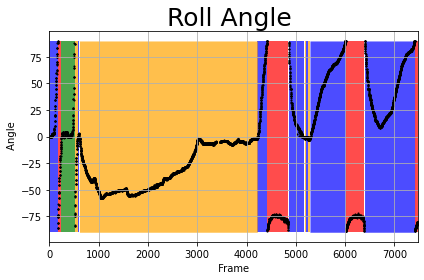

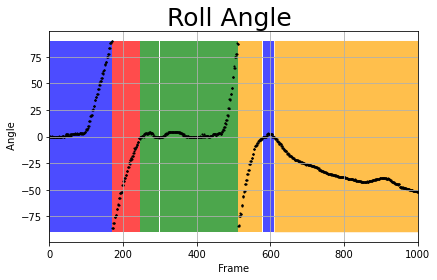

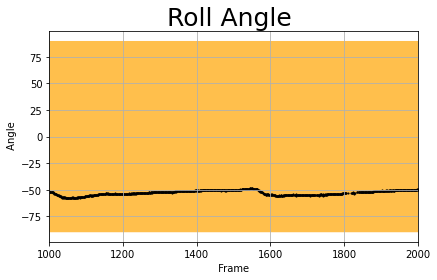

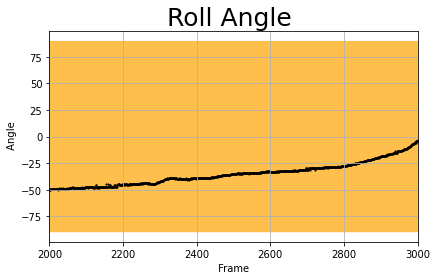

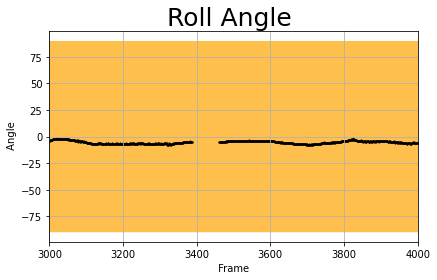

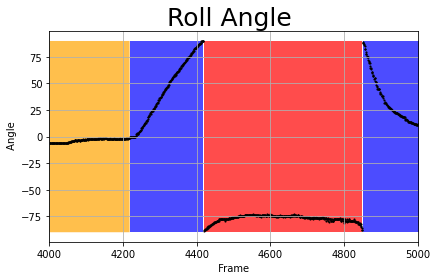

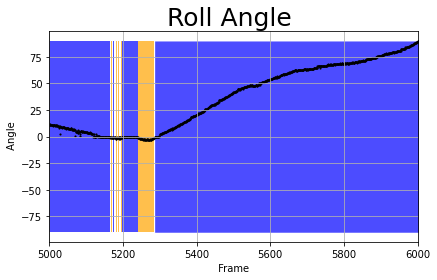

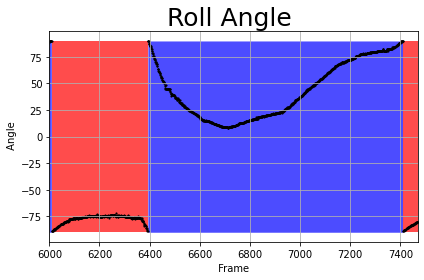

In [145]:
from turtle import color
df1 = pd.read_csv('csv/F5/roll_angle_1017_1055.csv')
df = df1.copy()
ran = [[0,7469],[0,1000,2000,3000,4000,5000,6000,7469]]
for s in range(len(ran)):
  for k in range(1,len(ran[s])):
    for column in df:
      inst = str(column)
      fig, ax = plt.subplots()
      x = df.index.tolist()
      y = df[column].values.tolist()
      cor = [None, 'blue', 'red', 'green', 'orange']
      

      for i in range(1,len(x_idx)):
        for j in range(0,len(x_idx[i]),2):
          ax.fill_between(range(x_idx[i][j],x_idx[i][j+1]), 90, -90, alpha=.7, linewidth=0, color = cor[i])  
      

      
      ax.scatter(x,y, marker=".", s =5, color = 'black')
      plt.grid ()
      plt.title("Roll Angle ",fontsize=25)
      plt.xlabel ( ' Frame ')
      plt.ylabel ( ' Angle')
      plt.tight_layout ()
      #path = '/content/graphs/' + column + "_2"+ '.png'
      #plt.savefig ( path , format = 'png' , dpi=400)
      plt.xlim((ran[s][k-1],ran[s][k]))
      plt.show()